In [63]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import re
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
import urllib.robotparser
# robots.txtの読み取り
robots_txt_url = 'https://suumo.jp/robots.txt'
rp = urllib.robotparser.RobotFileParser()
rp.set_url(robots_txt_url)
rp.read()
# robots.txtの情報から調査したいURL、User-Agentでクロール可能かを調べる
user_agent = '*'
url = 'https://qiita.com/api/*'
result = rp.can_fetch(user_agent, url)
print(result)

True


In [ ]:
class IchinowariScraper:
    def __init__(self):
        self.base_url = 'https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&pc=30&smk=&po1=25&po2=99&shkr1=03&shkr2=03&shkr3=03&shkr4=03&sc=11214&ta=11&cb=0.0&ct=9999999&et=9999999&mb=0&mt=9999999&cn=9999999&fw2=%E4%B8%80%E3%83%8E%E5%89%B2&page={}'
        self.data_samples = []

    def scrape_all(self):
        page = 1
        while True:
            url = self.base_url.format(page)
            res = requests.get(url)
            soup = BeautifulSoup(res.content, 'html.parser')
            
            mother = soup.find_all(class_='cassetteitem')
            if not mother: 
                break

            for child in mother:
                # 建物情報
                data_home = []
                data_home.append(child.find(class_='ui-pct ui-pct--util1').text) # カテゴリ
                data_home.append(child.find(class_='cassetteitem_content-title').text) # 建物名
                data_home.append(child.find(class_='cassetteitem_detail-col1').text) # 住所
                
                # アクセス情報
                children = child.find(class_='cassetteitem_detail-col2')
                for grandchild in children.find_all(class_='cassetteitem_detail-text'):
                    data_home.append(grandchild.text)
                
                # 築年数・階数
                children = child.find(class_='cassetteitem_detail-col3')
                for grandchild in children.find_all('div'):
                    data_home.append(grandchild.text)

                # 部屋情報
                rooms = child.find(class_='cassetteitem_other')
                for room in rooms.find_all(class_='js-cassette_link'):
                    data_room = []
                    for id_, grandchild in enumerate(room.find_all('td')):
                        if id_ == 2: # 階
                            data_room.append(grandchild.text.strip())
                        elif id_ == 3: # 家賃・管理費
                            data_room.append(grandchild.find(class_='cassetteitem_other-emphasis ui-text--bold').text)
                            data_room.append(grandchild.find(class_='cassetteitem_price cassetteitem_price--administration').text)
                        elif id_ == 4: # 敷金・礼金
                            data_room.append(grandchild.find(class_='cassetteitem_price cassetteitem_price--deposit').text)
                            data_room.append(grandchild.find(class_='cassetteitem_price cassetteitem_price--gratuity').text)
                        elif id_ == 5: # 間取り・面積
                            data_room.append(grandchild.find(class_='cassetteitem_madori').text)
                            data_room.append(grandchild.find(class_='cassetteitem_menseki').text)
                        elif id_ == 8: # URL
                            get_url = grandchild.find(class_='js-cassette_link_href cassetteitem_other-linktext').get('href')
                            data_room.append(urllib.parse.urljoin(url, get_url))

                    self.data_samples.append(data_home + data_room)
            
            print(f"{page}ページ目 取得完了")
            page += 1
            time.sleep(1) 
            
        return pd.DataFrame(self.data_samples)

scraper = IchinowariScraper()
df_ichinowari = scraper.scrape_all()

1ページ目 取得完了
2ページ目 取得完了
3ページ目 取得完了
4ページ目 取得完了
5ページ目 取得完了
6ページ目 取得完了
7ページ目 取得完了
8ページ目 取得完了
9ページ目 取得完了
10ページ目 取得完了
11ページ目 取得完了
12ページ目 取得完了
13ページ目 取得完了
14ページ目 取得完了
15ページ目 取得完了
16ページ目 取得完了


In [ ]:
class SengendaiScraper:
    def __init__(self):
        self.base_url = 'https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&pc=30&smk=&po1=25&po2=99&shkr1=03&shkr2=03&shkr3=03&shkr4=03&sc=11222&ta=11&cb=0.0&ct=9999999&et=20&mb=0&mt=9999999&cn=9999999&fw2=%E3%81%9B%E3%82%93%E3%81%92%E3%82%93%E5%8F%B0&page={}'
        self.data_samples = []

    def scrape_all(self, max_page=20):
        page = 1
        while True:
            if page > max_page:
                print(f"終了")
                break
                
            url = self.base_url.format(page)
            res = requests.get(url)
            soup = BeautifulSoup(res.content, 'html.parser')
            
            mother = soup.find_all(class_='cassetteitem')
            if not mother:
                print("物件が見つからないため終了します。")
                break

            for child in mother:
                data_home = []
                data_home.append(child.find(class_='ui-pct ui-pct--util1').text) 
                data_home.append(child.find(class_='cassetteitem_content-title').text) 
                data_home.append(child.find(class_='cassetteitem_detail-col1').text) 
                
                children = child.find(class_='cassetteitem_detail-col2')
                for grandchild in children.find_all(class_='cassetteitem_detail-text'):
                    data_home.append(grandchild.text)
           
                children = child.find(class_='cassetteitem_detail-col3')
                for grandchild in children.find_all('div'):
                    data_home.append(grandchild.text)

                rooms = child.find(class_='cassetteitem_other')
                for room in rooms.find_all(class_='js-cassette_link'):
                    data_room = []
                    for id_, grandchild in enumerate(room.find_all('td')):
                        if id_ == 2: #
                            data_room.append(grandchild.text.strip())
                        elif id_ == 3: 
                            data_room.append(grandchild.find(class_='cassetteitem_other-emphasis ui-text--bold').text)
                            data_room.append(grandchild.find(class_='cassetteitem_price cassetteitem_price--administration').text)
                        elif id_ == 4: 
                            data_room.append(grandchild.find(class_='cassetteitem_price cassetteitem_price--deposit').text)
                            data_room.append(grandchild.find(class_='cassetteitem_price cassetteitem_price--gratuity').text)
                        elif id_ == 5: 
                            data_room.append(grandchild.find(class_='cassetteitem_madori').text)
                            data_room.append(grandchild.find(class_='cassetteitem_menseki').text)
                        elif id_ == 8: 
                            get_url = grandchild.find(class_='js-cassette_link_href cassetteitem_other-linktext').get('href')
                            data_room.append(urllib.parse.urljoin(url, get_url))

                    
                    full_data = data_home + data_room
                    full_data.append("せんげん台")
                    full_data.append(1) 
                    self.data_samples.append(full_data)
            
            print(f"{page}ページ目 取得完了 (累計: {len(self.data_samples)}件)")
            page += 1
            time.sleep(1) 
            
        return pd.DataFrame(self.data_samples)


sengendai_scraper = SengendaiScraper()
df_sengendai = sengendai_scraper.scrape_all(max_page=20)

1ページ目 取得完了 (累計: 56件)
2ページ目 取得完了 (累計: 109件)
3ページ目 取得完了 (累計: 148件)
4ページ目 取得完了 (累計: 217件)
5ページ目 取得完了 (累計: 275件)
6ページ目 取得完了 (累計: 311件)
7ページ目 取得完了 (累計: 355件)
8ページ目 取得完了 (累計: 398件)
9ページ目 取得完了 (累計: 435件)
10ページ目 取得完了 (累計: 489件)
11ページ目 取得完了 (累計: 552件)
12ページ目 取得完了 (累計: 619件)
13ページ目 取得完了 (累計: 650件)
物件が見つからないため終了します。


In [ ]:
print("データの1件目:", scraper.data_samples[0])
print("データの要素数:", len(scraper.data_samples[0]))

データの1件目: ['賃貸アパート', 'ファミール一ノ割', '埼玉県春日部市一ノ割３', '東武伊勢崎線/一ノ割駅 歩11分', '東武伊勢崎線/武里駅 歩20分', '東武伊勢崎線/春日部駅 歩38分', '築36年', '2階建', '1階', '4.6万円', '2000円', '-', '-', '2K', '39.74m2', 'https://suumo.jp/chintai/jnc_000104334003/?bc=100485090720']
データの要素数: 16


In [ ]:
print(f"現在のデータは {df_sengendai.shape[1]} 列あります。")

現在のデータは 18 列あります。


In [ ]:
# 18個の項目名リスト
columns = [
    "カテゴリ", "建物名", "住所", "アクセス1", "アクセス2", "アクセス3", 
    "築年数", "構造", "階数", "家賃", "管理費", "敷金", "礼金", 
    "間取り", "面積", "URL", "駅名", "急行フラグ"
]

# DataFrameの作成と合体
df_s = pd.DataFrame(df_sengendai)
df_i = pd.DataFrame(df_ichinowari)
df_all = pd.concat([df_s, df_i], ignore_index=True)

# カラム名を割り当て（ここで数が一致しているので成功します）
df_all.columns = columns

# DBへ保存
conn = sqlite3.connect("suumo_comparison.db")
df_all.to_sql("properties", conn, if_exists='replace', index=False)

# 完了確認（最初の3件を表示）
check_df = pd.read_sql("SELECT * FROM properties LIMIT 3", conn)
conn.close()

print("--- 保存されたデータの確認 ---")
display(check_df)

--- 保存されたデータの確認 ---


,カテゴリ,建物名,住所,アクセス1,アクセス2,アクセス3,築年数,構造,階数,家賃,管理費,敷金,礼金,間取り,面積,URL,駅名,急行フラグ
0,賃貸マンション,コンティネント,埼玉県越谷市千間台西１,東武伊勢崎線/せんげん台駅 歩3分,,,築12年,5階建,2階,6.9万円,4600円,-,6.9万円,1K,27.91m2,https://suumo.jp/chintai/jnc_000104169251/?bc=...,せんげん台,1.0
1,賃貸マンション,ラフィーネＳＯＲＡ,埼玉県越谷市千間台西２,東武伊勢崎線/せんげん台駅 歩3分,東武伊勢崎線/大袋駅 歩14分,東武伊勢崎線/武里駅 歩25分,築10年,3階建,1階,8万円,5000円,8万円,8万円,1DK,36.12m2,https://suumo.jp/chintai/jnc_000104169252/?bc=...,せんげん台,1.0
2,賃貸テラス・タウンハウス,サン マルツァーノ,埼玉県越谷市大字大泊,東武伊勢崎線/せんげん台駅 歩17分,東武伊勢崎線/大袋駅 歩24分,東武伊勢崎線/武里駅 歩29分,築13年,地上2階建,1-2階,8.5万円,3000円,-,-,2LDK,65.4m2,https://suumo.jp/chintai/jnc_000104309797/?bc=...,せんげん台,1.0


In [51]:
import pandas as pd

# カラム名（列の名前）を定義
columns = [
    "カテゴリ", "建物名", "住所", "アクセス1", "アクセス2", "アクセス3", 
    "築年数", "構造", "階数", "家賃", "管理費", "敷金", "礼金", 
    "間取り", "面積", "URL", "駅名", "急行フラグ"
]

# 1. せんげん台と一ノ割のデータを合体させる
# ※スクレイピング結果のリスト(data_samples)から作成する場合
df_sengendai_fmt = pd.DataFrame(df_sengendai, columns=columns)
df_ichinowari_fmt = pd.DataFrame(df_ichinowari, columns=columns)

# 2. 一つのデータフレームにまとめる（これが df_all になる）
df_all = pd.concat([df_sengendai_fmt, df_ichinowari_fmt], ignore_index=True)

print(f"合体完了！ 全 {len(df_all)} 件のデータが df_all に入りました。")

合体完了！ 全 1485 件のデータが df_all に入りました。


In [52]:
import sqlite3

# DBに接続
conn = sqlite3.connect("suumo_comparison.db")
cur = conn.cursor()

# テーブルの作成（既存があれば消す）
cur.execute("DROP TABLE IF EXISTS properties")
create_table_sql = """
CREATE TABLE properties (
    カテゴリ TEXT, 建物名 TEXT, 住所 TEXT, アクセス1 TEXT, アクセス2 TEXT, アクセス3 TEXT,
    築年数 TEXT, 構造 TEXT, 階数 TEXT, 家賃 TEXT, 管理費 TEXT, 敷金 TEXT, 礼金 TEXT,
    間取り TEXT, 面積 TEXT, URL TEXT, 駅名 TEXT, 急行フラグ INTEGER
);
"""
cur.execute(create_table_sql)

# 復活した df_all を流し込む
df_all.to_sql("properties", conn, if_exists='append', index=False)

conn.commit()
conn.close()

print("DBへの保存が正常に完了しました！")

DBへの保存が正常に完了しました！


In [ ]:
# DBに接続
conn = sqlite3.connect("suumo_comparison.db")

# クエリ発行
query = """
SELECT 
    駅名,
    急行フラグ,
    建物名,
    CAST(REPLACE(家賃, '万円', '') AS REAL) AS 家賃_万円,
    CAST(REPLACE(面積, 'm2', '') AS REAL) AS 面積_m2,
    間取り
FROM 
    properties
"""


df_analysis = pd.read_sql(query, conn)
conn.close()


print("数値変換後のデータ:")
display(df_analysis.head())

avg_rent = df_analysis.groupby("駅名")["家賃_万円"].mean()
print("\n駅ごとの平均家賃:")
print(avg_rent)

数値変換後のデータ:


,駅名,急行フラグ,建物名,家賃_万円,面積_m2,間取り
0,せんげん台,1.0,コンティネント,6.9,27.91,1K
1,せんげん台,1.0,ラフィーネＳＯＲＡ,8.0,36.12,1DK
2,せんげん台,1.0,サン マルツァーノ,8.5,65.40,2LDK
3,せんげん台,1.0,プレ・ド・ラ・ガールせんげん台,8.0,40.31,1LDK
4,せんげん台,1.0,プロシードせんげん台２,6.7,54.79,2LDK



駅ごとの平均家賃:
駅名
せんげん台    8.121292
Name: 家賃_万円, dtype: float64


In [ ]:
# DBに接続
conn = sqlite3.connect("suumo_comparison.db")

# クエリ：アクセス1に「歩1分」〜「歩10分」が含まれるものを抽出
query = """
SELECT 
    駅名,
    COUNT(*) as 徒歩10分以内の物件数,
    AVG(CAST(REPLACE(家賃, '万円', '') AS REAL)) as 平均家賃_万円
FROM 
    properties
WHERE 
    (アクセス1 LIKE '%歩1分%' OR 
     アクセス1 LIKE '%歩2分%' OR 
     アクセス1 LIKE '%歩3分%' OR 
     アクセス1 LIKE '%歩4分%' OR 
     アクセス1 LIKE '%歩5分%' OR 
     アクセス1 LIKE '%歩6分%' OR 
     アクセス1 LIKE '%歩7分%' OR 
     アクセス1 LIKE '%歩8分%' OR 
     アクセス1 LIKE '%歩9分%' OR 
     アクセス1 LIKE '%歩10分%')
GROUP BY 
    駅名
"""

df_walk_10 = pd.read_sql(query, conn)
conn.close()

print("--- 徒歩10分以内の物件集計 ---")
display(df_walk_10)

--- 徒歩10分以内の物件集計 ---


,駅名,徒歩10分以内の物件数,平均家賃_万円
0,せんげん台,350,8.799286
1,一ノ割,483,6.410041


/var/folders/sy/rjj2rtts04qbctf_pqb2y_y00000gn/T/ipykernel_65522/2855956807.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='駅名', y='平均家賃_万円', data=df_walk_10, ax=ax1[0], palette='viridis')
/var/folders/sy/rjj2rtts04qbctf_pqb2y_y00000gn/T/ipykernel_65522/2855956807.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='駅名', y='徒歩10分以内の物件数', data=df_walk_10, ax=ax1[1], palette='magma')


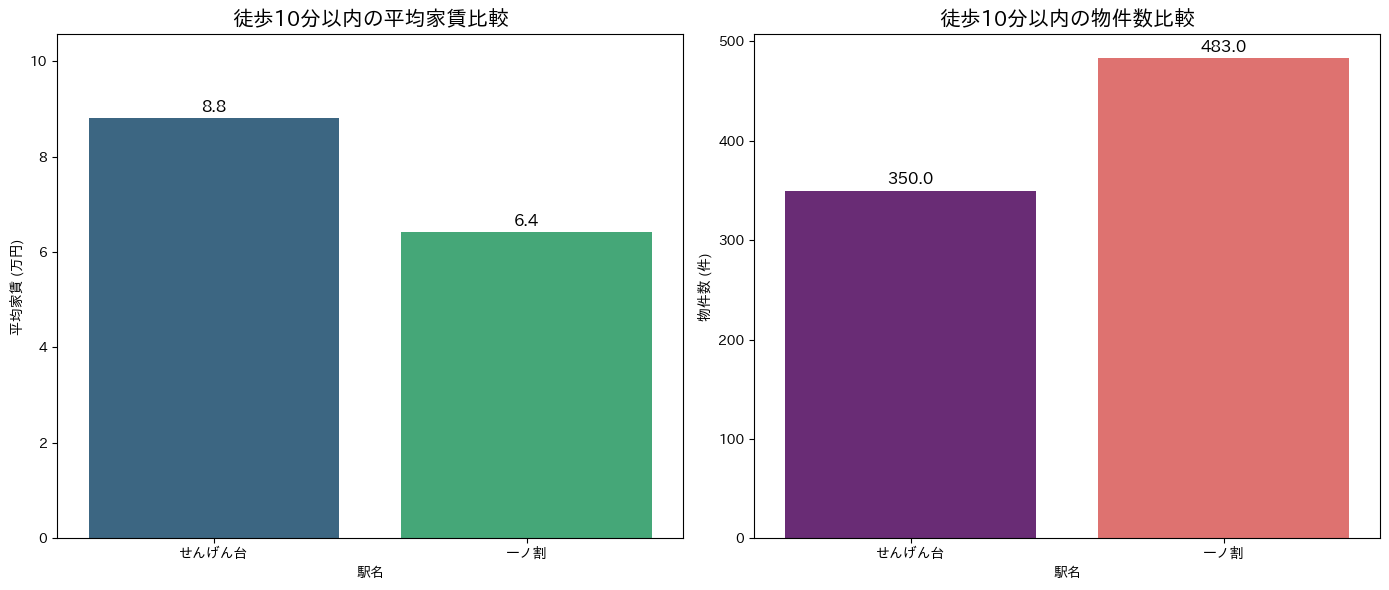

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'sans-serif'
try:
    
    import japanize_matplotlib
except ImportError:

    pass


fig, ax1 = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x='駅名', y='平均家賃_万円', data=df_walk_10, ax=ax1[0], palette='viridis')
ax1[0].set_title('徒歩10分以内の平均家賃比較', fontsize=15)
ax1[0].set_ylabel('平均家賃 (万円)')
ax1[0].set_ylim(0, df_walk_10['平均家賃_万円'].max() * 1.2) # 上部に少し余裕を持たせる

sns.barplot(x='駅名', y='徒歩10分以内の物件数', data=df_walk_10, ax=ax1[1], palette='magma')
ax1[1].set_title('徒歩10分以内の物件数比較', fontsize=15)
ax1[1].set_ylabel('物件数 (件)')

for ax in ax1:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 8),
                    textcoords='offset points')

plt.tight_layout()
plt.show()